# Description of the QAOA algorithm

descripton text and pictures

### Install Qucircuit
Ensure you have qucircuit installed, the next cell has `pip install` for that.  
Also, take a look [here](https://github.com/atulvarshneya/quantum-computing/tree/master/examples/qckt) for several example algorithm implementations, as well as Getting Started tutorials on qckt.

In [2]:
%pip install qucircuit -qU

Note: you may need to restart the kernel to use updated packages.


## Imports

* Import the qckt package modules - this is used to build the quantum circuit for the QAOA algorithm, run it, and collect the measured outputs.
* Import the optimization function from scipy.optimize - this is used for the classical part of the QAOA algorithm.
* Rest of the imports - numpy, and matplotlib are used for general computations and plots to visualize the working of the various steps of the algorithm.

In [3]:
import qckt
import qckt.backend as bknd
import qckt.noisemodel as ns
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

pi = np.pi

## Class to construct and run QC circuit for QAOA

In [4]:

class qaoa_qc_circuit:
    # Class to run QAOA for a problem specification
    def __init__(self, edges, n_vertices, n_layers, n_shots):
        self.edges = edges
        self.n_vertices = n_vertices
        self.n_qubits = n_vertices
        self.n_layers = n_layers
        self.n_shots = n_shots
        self.results = []

    # Each run call is for a given pair of gamma and beta
    def run(self, gammavals, betavals):
        ckt = self.full_qaoa_ckt(n_qubits=self.n_qubits, n_layers=self.n_layers, edges=self.edges, gammavals=gammavals, betavals=betavals)

        # Optionally: try with a noisey quantum computer
        # noise_profile = ns.NoiseProfile(noise_chan_allgates=ns.bit_flip(0.0002))
        # ckt.set_noise_profile(noise_profile=noise_profile)

        job = qckt.Job(ckt, shots=self.n_shots, qtrace=True)
        bkeng = bknd.DMQeng()
        bkeng.runjob(job)

        creg_counts = job.get_counts()
        return creg_counts
    
    # QAOA Circuit components

    # Initial state U_init
    def qaoa_init(self, ckt, n_qubits):
        ckt.H(list(range(n_qubits)))  # Initial Hadamard
        return ckt


    # Cost Hamiltonian U_C(gamma)
    def qaoa_cost(self, ckt, n_qubits, edges, gamma):
        # U_C(gamma)
        for e in edges:
            ckt.CX(e[0], e[1])
            ckt.Rz(-gamma, e[1])
            ckt.CX(e[0], e[1])
        return ckt


    # Mixer Hamiltonian U_B(beta)
    def qaoa_mixer(self, ckt, n_qubits, beta):
        # U_B(beta)
        ckt.H(list(range(n_qubits)))
        ckt.Rz(2*beta, list(range(n_qubits)))
        ckt.H(list(range(n_qubits)))
        return ckt


    # One QAOA layer
    def qaoa_layer(self, ckt, n_qubits, edges, gamma, beta):
        # U_C(gamma)
        ckt = self.qaoa_cost(ckt, n_qubits, edges, gamma)
        # U_B(beta)
        ckt = self.qaoa_mixer(ckt, n_qubits, beta)
        return ckt


    # Build full QAOA circuit
    def full_qaoa_ckt(self, n_qubits, n_layers, edges, gammavals, betavals):
        ckt = qckt.QCkt(n_qubits,n_qubits)
        ckt = self.qaoa_init(ckt, n_qubits)
        ckt.Border()
        for i in range(n_layers):
            ckt = self.qaoa_layer(ckt, n_qubits, edges, gammavals[i], betavals[i])
            ckt.Border()
        # ckt.M(list(range(n_qubits-1,0-1,-1)), list(range(n_qubits-1,0-1,-1)))
        return ckt


## Functions for loss and cut-value calculations
Terminology:  
* **cost**: the cut-value of a given graph cut. A graph cut is represented by assiging a 0 or a 1 to each vertex in the graph. Thus an edge (v1, v2) connecting vertices v1 and v2 will contribute cost of 1 if v1 and v2 have different values assigned to them, else 0. The cost or cut-value is the sum of cost contribution from all edges. MAXCUT problem aims to find a cut that has the *maximum* cost/cut-value for a given graph.
![Example of cut in a graph](images/QAOA-Diagrams/Slide4.PNG)
* **loss**: running the qaoa quantum circuit nshot times will yield nshot outputs. Each output represents a cut. Adding up the cost (or cut-value) of all the outputs yields total cost or total cut-value. We aim to find gamma and beta vlaues that maximize this number, hence loss is defined as the -ve of that number, and the aim of the algorithm is to minimize it.

In [5]:
# convert measurement result to bitstring
def meas_result_to_bitstring(meas_result, n_qubits):
    bitstring = ''
    for i in range(n_qubits):
        bit = (meas_result >> i) & 1
        bitstring = str(bit) + bitstring
    return bitstring

# Cost function
def qaoa_cost_function(bitstring, edges):
    n_vertices = len(bitstring)
    cost = 0
    for e in edges:
        if bitstring[n_vertices-e[0]-1] != bitstring[n_vertices-e[1]-1]:
            cost += 1
    return cost

# Loss function
def qaoa_loss(counts, edges, n_vertices):
    total_cost = 0
    total_counts = 0
    for meas_result, count in counts.items():
        bitstring = meas_result_to_bitstring(meas_result, n_vertices)
        cost = qaoa_cost_function(bitstring, edges)
        total_cost += cost * count
        total_counts += count
    avg_cost = total_cost / total_counts
    return -avg_cost  # We minimize negative of cost


# create a bitstring to counts and cost data frame
def counts_cost_df(counts, edges, n_qubits):
    df = []
    for meas_result in range(2**n_qubits):
        count = counts.get(meas_result,0)
        bitstring = meas_result_to_bitstring(meas_result, n_qubits)
        df.append({"bitstring": bitstring, "count": count, "cost": qaoa_cost_function(bitstring, edges)})
    return df

## Problem specs

Specification of the graph for which MAXCUT is to be determined.

Provide list of edges, and the number of vertices in the graph.

![Examples](images/QAOA-Diagrams/Slide3.png)

In [6]:
# Example 1
# edges = [(0, 1), (2, 0)]
# n_vertices = 3

# Example 2
# edges = [(0, 1), (1, 2), (2,3), (3,0), (1,4), (4,2)]
# n_vertices = 5

# Example 3
edges = [(0,1), (0,2), (0,3), (0,4), (0,5), (1,2), (1,3), (1,4), (1,5), (2,3), (2,4), (2,5), (3,4), (3,5), (4,5)]
n_vertices = 6

## Find optimal gamma and beta - Nelder-Mead method (scipy.optimize.minimize)

### Utility function to plot gamma and beta evolution at each optimization step
this is just a nice to have capability. This helps to visualize how the scipy.optimize.minimize incrementally tunes the gamma and beta values -- some insight into the working of the classical part of the algorithm.

In [7]:
def plot_gamma_beta_evolution(trace):
    # Plot gamma evolution over iterations, and another plot for gamma and beta evolotion over iteration
    plt.figure(figsize=(8, 5))
    for i in range(len(trace[0]['gammavals'])):
        plt.plot([item['gammavals'][i] for item in trace], marker='o', label=f"Gamma{i}")
    for i in range(len(trace[0]['betavals'])):
        plt.plot([item['betavals'][i] for item in trace], marker='o', label=f"Beta{i}")
    plt.xlabel('Iteration')
    plt.ylabel('Gamma and Beta')
    plt.title('Gamma and Beta Evolution Over Iterations')
    plt.legend()
    plt.grid()
    plt.show()

### Create an objective function

We will need to create different sized circuits at different steps of the hyperparameter optimization process.  
So, we use a function to create a parameterized objective function which constructs the circuit of the required `n_layers` for that optimization step, runs it `n_shots` times, collects the measurements, and returns the corresponding `loss` value. The objective function can then be called with the only variable parameters - `gamma` and `beta` values - to optimize them.

In [8]:
def get_objective_function(edges, n_vertices, n_layers, n_shots):
    def objective_function(params):
        # print(f'N_vertices: {n_vertices}, Edges: {edges}, N_Layers: {n_layers}, N_shots: {n_shots}')
        gammavals = params[0:n_layers]
        betavals = params[n_layers:]
        qaoa_ckt = qaoa_qc_circuit(edges=edges,n_vertices=n_vertices, n_layers=n_layers, n_shots=n_shots )
        counts = qaoa_ckt.run(gammavals, betavals)
        loss = qaoa_loss(counts=counts, edges=edges, n_vertices=n_vertices)
        return loss
    return objective_function

def callback_fn(intermediate_result):
    global trace
    split = int(len(intermediate_result.x) / 2)
    gammavals = intermediate_result.x[0:split]
    betavals = intermediate_result.x[split:]
    loss = intermediate_result.fun
    trace.append({"gammavals":gammavals, "betavals":betavals, "loss":loss})



### Optimization Process

QAOA involves creating a quantum cicuit with `p` layers of `U_C(gamma)` and `U_B(beta)` operators, and then reading out the result, which is potentially the solution of the optimization problem. 'potentially' because the values of `gamma` and `beta` when optimized result in the solution. The optimization of the `gamma` and `beta` parameters are done using classical computer algorithm, such as Nelder-Mead, Grid Search, etc. For this the quantum circuit is run several times with different `gamma` and `beta` parameter values, and `loss` value is computed for each output. Using this the classical optimization algorithm computes the optimal `gamma` and `beta` values.

Theoretically, the larger the value of `p`, the more accurate the quantum circuit outputs. However, for large `p` the loss function is very jagged and not smooth. While for `p` = 1, it is quite smooth and sinusoidal-ish in shape. So, the approch that is proactically followed often is to start with `p` = 1, and determine the optimal `gamma` and `beta` values for that. Next, use these gamma and beta values as starting ones for a circuit with `p` = 2 (2 layers) and find the optimal gamma and beta values for that sized circuit. Next, these are used as the starting values for `p` = 3, or 4. Typically, this is sufficient, and no larger circuits are used.

So we follow this scheme below, starting with a circuit where `p` = 1, next use the optimized `gamma` and `beta` got from this to start for circuit with `p` = 2, then the same for `p` = 3 (or 4).

Note: as we run each of these steps, we maintain a trace of - `gamma` and `beta` values, the measurements from each circuit run (multi-shot run), and the corresponding `loss` values.

### Step 1

`p` = 1

`gamma` and `beta` given some initial values as starting values.

Maximum number of iterations has been exceeded.


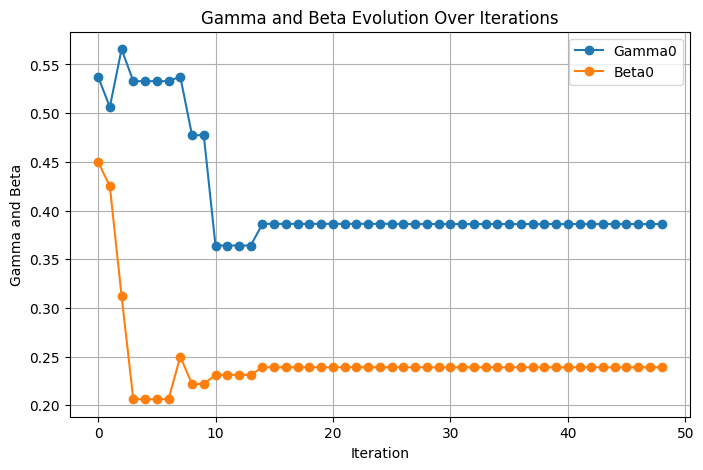

In [9]:
n_layers1 = 1  # p parameter
n_shots1 = 2000
maxiter1 = 50

gammavals_init = [0.5]
betavals_init = [0.5]
params = gammavals_init + betavals_init

f = get_objective_function(edges=edges, n_vertices=n_vertices, n_layers=n_layers1, n_shots=n_shots1)

trace = []
opt_res1= minimize(
    f, 
    params, 
    method='Nelder-Mead', 
    options={'maxiter': maxiter1},
    callback=callback_fn,
    )
print(opt_res1.message)
plot_gamma_beta_evolution(trace)

### Step 2

`p` = 2

`gamma` and `beta` starting values as the optimized values from previous step

Maximum number of iterations has been exceeded.


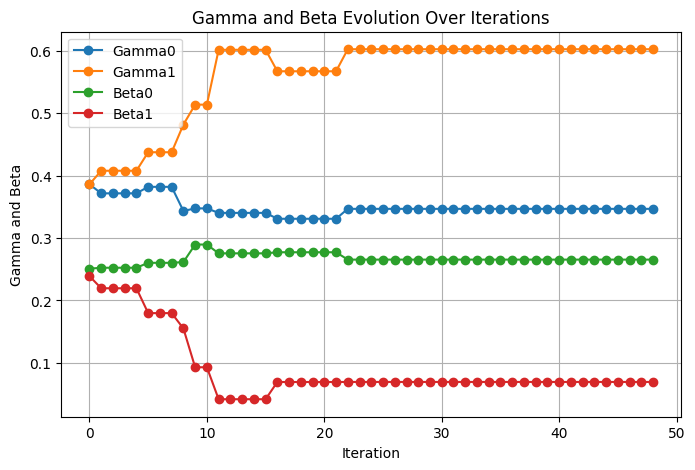

In [10]:
n_layers2 = 2  # p parameter
n_shots2 = 2000
maxiter2 = 50

split = int(len(opt_res1.x) / 2)
res_x = (opt_res1.x).tolist()
gammavals = res_x[0:split] + [res_x[0]]*(n_layers2 - n_layers1)  # the optimal values from previous step, extended by a value for the additional layer
betavals = res_x[split:] + [res_x[split]]*(n_layers2 - n_layers1)  # the optimal values from previous step, extended by a value for the additional layer
params = gammavals + betavals

f = get_objective_function(edges=edges, n_vertices=n_vertices, n_layers=n_layers2, n_shots=n_shots2)

trace = []
opt_res2 = minimize(
    f, 
    params, 
    method='Nelder-Mead', 
    options={'maxiter': maxiter2},
    callback=callback_fn,
    )
print(opt_res2.message)
plot_gamma_beta_evolution(trace)

### Step 3

`p` = 3

`gamma` and `beta` starting values as the optimized values from previous step

Maximum number of iterations has been exceeded.


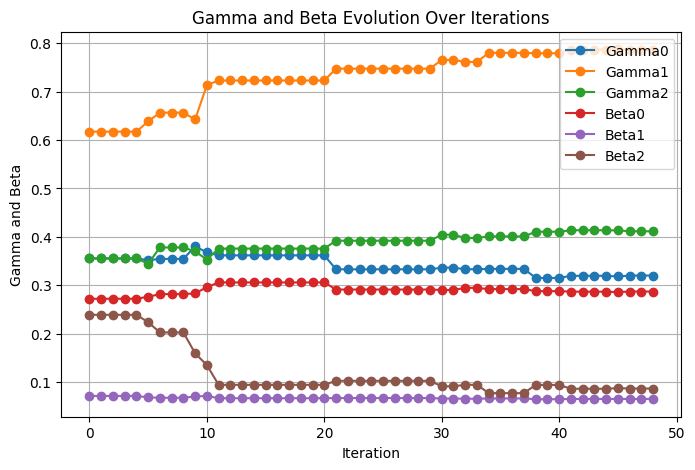

In [11]:
n_layers3 = 3  # p parameter
n_shots3 = 2000
maxiter3 = 50

split = int(len(opt_res2.x) / 2)
res_x = (opt_res2.x).tolist()
gammavals = res_x[0:split] + [res_x[0]]*(n_layers3 - n_layers2)  # the optimal values from previous step, extended by a value for the additional layer
betavals = res_x[split:] + [res_x[split]]*(n_layers3 - n_layers2)  # the optimal values from previous step, extended by a value for the additional layer
params = gammavals + betavals

f = get_objective_function(edges=edges, n_vertices=n_vertices, n_layers=n_layers3, n_shots=n_shots3)

trace = []
opt_res3 = minimize(
    f, 
    params,
    method='Nelder-Mead', 
    options={'maxiter': maxiter3},
    callback=callback_fn,
    )
print(opt_res3.message)
plot_gamma_beta_evolution(trace)

## Lookup and visualize the result

At this stage, the values of gamma and beta are typically obtained which lead to high probability of measuring the optimal solution from the quantum circuit.

We pick out from the trace the result of the circuit run using those parameter values and visualize tehm. Since we are running the circuit multi-shot, the results give us the frequency of the various results measured. The best values are seen to have significantly large frequencies, i.e., high likelihood of being the measured result.

<function matplotlib.pyplot.show(close=None, block=None)>

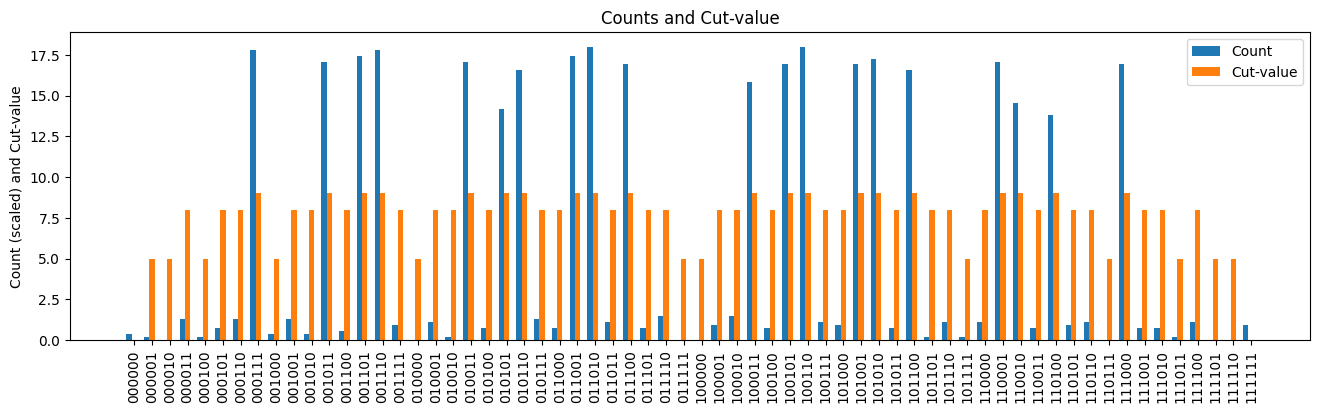

In [12]:
# Use the optimal values of gamma and beta to compute the qc circuit output
split = int(len(opt_res3.x) / 2)
res_x = (opt_res3.x).tolist()
gammavals = res_x[0:split]  # the optimal values from previous step
betavals = res_x[split:]  # the optimal values from previous step

qaoa_ckt = qaoa_qc_circuit(edges=edges,n_vertices=n_vertices, n_layers=n_layers3, n_shots=n_shots3 )
best_counts = qaoa_ckt.run(gammavals, betavals)

# create bitstring vs counts and costs
df = counts_cost_df(best_counts, edges, n_vertices)

labels = [row['bitstring'] for row in df]
counts_unscaled = [row['count'] for row in df]
costs = [row['cost'] for row in df]

scale = max(counts_unscaled) / max(costs)
counts = [2*i / scale for i in counts_unscaled]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(16, 4))
rects1 = ax.bar(x - width, counts, width, label='Count')
rects2 = ax.bar(x, costs, width, label='Cut-value')
ax.set_ylabel('Count (scaled) and Cut-value')
ax.set_title('Counts and Cut-value')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()
plt.show


In [13]:
maxcut = max(costs)
freq_good = 0
freq_bad = 0
for i,c in enumerate(costs):
    if c == maxcut:
        freq_good += counts_unscaled[i]
    else:
        freq_bad += counts_unscaled[i]

print(f"Percentage of good results: {100.0 * freq_good/(freq_good+freq_bad)}%")
print(f"Frequency of good results: {freq_good}, Frequency of bad results: {freq_bad}")


Percentage of good results: 91.9%
Frequency of good results: 1838, Frequency of bad results: 162
